#### Prepare Dataset
- Install Packages
- Import Packages
- Download Data

##### Install Packages

In [1]:
# pip install copernicus_marine_client

In [2]:
# pip install keras-tuner --upgrade

##### Import Packages

In [3]:
import os
import xarray as xr
import copernicus_marine_client as copernicusmarine

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l1_l2
import keras_tuner

2023-12-22 01:59:40.268184: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-22 01:59:40.312803: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
random_seed = 5
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed) #try to get same result every time...

##### Download Data  
- Download data from source website form two dataset_id
- Merge two dataset

In [5]:
# Download data from source website form two dataset_id
copernicusmarine.login("xfeng4","Sf1260358662@") #login, overwrite it ? [y/N]: y

#field name in dataset
data_variables = ["sithick","siconc","thetao","bottomT","so", "usi", "vsi","uo","vo"]

#create folder to store raw data
cwd = os.getcwd()
folder = "sea ice thickness dataset"

site = {
"greenland": (-58.133, -57.718, 82.892, 83.307),
"bering_strait": (-174.477, -172.402, 76.268, 78.343)} #create dictionary: {site: min_long, max_long, min_lat, max_long}

active_site = "greenland" #current running site
folder_path = os.path.join(cwd, folder, active_site) 
os.makedirs(folder_path, exist_ok=True) 

File /home/jovyan/.copernicus-marine-client/.copernicus-marine-credentials already exists, overwrite it ? [y/N]:

  y


INFO - 2023-12-22T01:59:47Z - Credentials file stored in /home/jovyan/.copernicus-marine-client/.copernicus-marine-credentials.


In [6]:
#first dataset
for var in data_variables:
    output_file = os.path.join(folder_path, f"{var}_id1.nc")
    if os.path.exists(output_file):
        pass
    else:
        copernicusmarine.subset(
          dataset_id="cmems_mod_glo_phy_my_0.083deg_P1D-m",
          variables=[var],
          minimum_longitude=site[active_site][0],
          maximum_longitude=site[active_site][1],
          minimum_latitude=site[active_site][2],
          maximum_latitude=site[active_site][3],
          start_datetime="1993-01-01T00:00:00",
          end_datetime="2021-06-30T23:59:59",
          output_filename=output_file)

#second dataset ID
for var in data_variables:
    output_file = os.path.join(folder_path, f"{var}_id2.nc")
    if os.path.exists(output_file):
        pass
    else:
        copernicusmarine.subset(
          dataset_id="cmems_mod_glo_phy_myint_0.083deg_P1D-m",
          variables=[var],
          minimum_longitude=site[active_site][0],
          maximum_longitude=site[active_site][1],
          minimum_latitude=site[active_site][2],
          maximum_latitude=site[active_site][3],
          start_datetime="2021-07-01T00:00:00",
          end_datetime="2023-07-31T23:59:59",
          output_filename=os.path.join(folder_path, f"{var}_id2.nc"))
        
print("down")

down


In [7]:
#Merge two dataset
os.makedirs(os.path.join(folder_path, "Merged"), exist_ok=True) 

for var in data_variables:
    output_file = os.path.join(folder_path, "Merged", f"{var}_merged.nc")
    if os.path.exists(output_file):
        pass
    else:
        data_id1_file = os.path.join(folder_path, f"{var}_id1.nc")
        data_id2_file = os.path.join(folder_path, f"{var}_id2.nc")
        data_id1_xr = xr.open_dataset(data_id1_file)
        data_id2_xr = xr.open_dataset(data_id2_file)
        data_xr = xr.merge([data_id1_xr, data_id2_xr])
        data_file = os.path.join(folder_path, "Merged", f"{var}_merged.nc")
        data_xr.to_netcdf(data_file)
        
print("down")

down


#### Process Data
- read as xarray, drop "depth" dimension, and merge xrray
- normalization
- flat data for NN
- time slider for LSTM

##### Read as xarray, drop "depth" dimension, and merge xarray

In [8]:
#extract training_data
#create variable for time slice
training_time_range = slice('1993-01-01', '2018-12-31')
testing_time_range = slice('2019-01-01', '2023-07-31')

input_features = ["siconc","thetao","bottomT","so", "usi", "vsi","uo","vo"]
output_features = ["sithick"]

training_data = {}
for var in data_variables:
    data_file = os.path.join(folder_path, "Merged", f"{var}_merged.nc")
    selection_dataset = xr.open_dataset(data_file)
    selection_dataset_time = selection_dataset.sel(time=training_time_range)

    if 'depth' in selection_dataset_time[var].dims: #drop "depth" if it exists
        selection_dataset_time[var] = selection_dataset_time[var].mean(dim='depth')
        selection_dataset_time = selection_dataset_time.drop_vars("depth")
        check_nans = selection_dataset_time[var].isnull().any()
        if check_nans: #complete data via linear interpolate
            selection_dataset_time[var] = selection_dataset_time[var].interpolate_na(dim='time')
    else:
        check_nans = selection_dataset_time[var].isnull().any()
        if check_nans:
            selection_dataset_time[var] = selection_dataset_time[var].interpolate_na(dim='time')

    training_data[var] = selection_dataset_time

#check if dimensions same: only keep time, lat and lon
dimensions = None
for var, dataset in training_data.items():
    if dimensions is None:
        dimensions = dataset.dims
    elif dimensions != dataset.dims:
        raise ValueError(f"Dimension mismatch in variable {var}")

train = xr.merge([training_data[var] for var in data_variables])

#get input and output variables 
x_train_xr = train[input_features]
y_train_xr = train[output_features]

In [9]:
#extract testing_data
#write a function for extract and merge
testing_data = {}
for var in data_variables:
    data_file = os.path.join(folder_path, "Merged", f"{var}_merged.nc")
    selection_dataset = xr.open_dataset(data_file)
    selection_dataset_time = selection_dataset.sel(time=testing_time_range)

    if 'depth' in selection_dataset_time[var].dims:
        selection_dataset_time[var] = selection_dataset_time[var].mean(dim='depth')
        selection_dataset_time = selection_dataset_time.drop_vars("depth")
        check_nans = selection_dataset_time[var].isnull().any()
        if check_nans:
            selection_dataset_time[var] = selection_dataset_time[var].interpolate_na(dim='time')
    else:
        check_nans = selection_dataset_time[var].isnull().any()
        if check_nans:
            selection_dataset_time[var] = selection_dataset_time[var].interpolate_na(dim='time')

    testing_data[var] = selection_dataset_time
    
dimensions = None
for var, dataset in testing_data.items():
    if dimensions is None:
        dimensions = dataset.dims
    elif dimensions != dataset.dims:
        raise ValueError(f"Dimension mismatch in variable {var}")

test = xr.merge([testing_data[var] for var in data_variables])

x_test_xr = test[input_features]
y_test_xr = test[output_features]

##### Normalization

In [10]:
meanstd_inputs = {}
predictors = input_features

def normalize(data, var, meanstd_dict):
    mean = meanstd_dict[var][0]
    std = meanstd_dict[var][1]
    return (data - mean)/std

for var in predictors:
    meanstd_inputs[var] = (x_train_xr[var].data.mean(), x_train_xr[var].data.std())
    
# normalize each variables
for var in predictors:
    # training set
    var_dims   = x_train_xr[var].dims
    x_train_xr = x_train_xr.assign({var: (var_dims, normalize(x_train_xr[var].data, var, meanstd_inputs))})
    
    # test set
    var_dims  = x_test_xr[var].dims
    x_test_xr = x_test_xr.assign({var: (var_dims, normalize(x_test_xr[var].data, var, meanstd_inputs))})

In [11]:
x_train_np  = x_train_xr.to_array().transpose('time', 'latitude', 'longitude', 'variable').data
x_test_np  = x_test_xr.to_array().transpose('time', 'latitude', 'longitude', 'variable').data

y_train_np = y_train_xr[output_features[0]].data
y_test_np = y_test_xr[output_features[0]].data

print(x_train_np.shape, x_test_np.shape, y_train_np.shape, y_test_np.shape)

(9496, 5, 5, 8) (1673, 5, 5, 8) (9496, 5, 5) (1673, 5, 5)


In [12]:
#check n_lat and n_long and extract shape value
if x_train_np.shape[1:3] == x_test_np.shape[1:3] == y_train_np.shape[1:3] == y_test_np.shape[1:3]:
    n_lat, n_lon = x_train_np.shape[1:3]

print(n_lat, n_lon)

5 5


##### Flat data for NN

In [13]:
#convert model to 1D for NN
x_train_flattened = x_train_np.reshape(x_train_np.shape[0], -1)  # x_train.shape[0] is the number of samples
y_train_flattened = y_train_np.reshape(y_train_np.shape[0], -1)
x_test_flattened = x_test_np.reshape(x_test_np.shape[0], -1)

##### Add time slider for LSTM

In [14]:
#adjust dataset to feed LSTM
slider = 5
x_train_slider = np.array([x_train_np[i:i+slider] for i in range(0, x_train_np.shape[0]-slider+1)])
y_train_slider = np.array([y_train_np[i+slider-1] for i in range(0, y_train_np.shape[0]-slider+1)])
y_train_slider = y_train_slider.reshape(y_train_slider.shape[0], 1, y_train_slider.shape[1], y_train_slider.shape[2])

x_test_slider = np.array([x_test_np[i:i+slider] for i in range(0, x_test_np.shape[0]-slider+1)])

print(x_train_np.shape, x_train_slider.shape)
print(y_train_np.shape, y_train_slider.shape)
print(x_test_np.shape, x_test_slider.shape)

#stack them to get shape (n_timepoints, n_slider, features)
input_shape = (slider, n_lat, n_lon, (len(data_variables)-1))  # time slider, lat, long, features
output_shape = (1, n_lat, n_lon)    # lat, long

# Flatten the spatial dimensions for the LSTM input
flattened_spatial_dim = input_shape[1] * input_shape[2] * input_shape[3]

(9496, 5, 5, 8) (9492, 5, 5, 5, 8)
(9496, 5, 5) (9492, 1, 5, 5)
(1673, 5, 5, 8) (1669, 5, 5, 5, 8)


#### Train the model
- NN
- CNN + keras_tuner
- LSTM + keras_tuner
- CNN LSTM + keras_tuner  
*how to do feature selection?*

##### NN

In [15]:
#set parameters
method = "NN"

n_neuron       = 256 #the number of n_neuron
activation     = 'relu' #activation methods
num_epochs     = 50 #go through how many times weight adjusted
learning_rate  = 0.001 #related to optimize
minibatch_size = 64 #the batch to calculate delta to optimize
N_layers       = 3 #number of hidden layers

In [16]:
# loss = "mse"
model_mse = Sequential()
model_mse.add(Dense(n_neuron,  activation=activation, name="hidden_layer_1" ,input_shape=(x_train_flattened.shape[1],)))
for n in range(N_layers-1):
    model_mse.add(Dense(n_neuron,  activation=activation, name="hidden_layer_"+str(n+2))) 
model_mse.add(Dense(y_train_flattened.shape[1],  activation="linear", name="output_layer")) # the output layer
model_mse.compile(loss="mse",optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

model_mse.summary()

# lose = "mae"
model_mae = Sequential()
model_mae.add(Dense(n_neuron,  activation=activation, name="hidden_layer_1" ,input_shape=(x_train_flattened.shape[1],)))
for n in range(N_layers-1):
    model_mae.add(Dense(n_neuron,  activation=activation, name="hidden_layer_"+str(n+2))) 
model_mae.add(Dense(y_train_flattened.shape[1],  activation="linear", name="output_layer")) # the output layer
model_mae.compile(loss='mae',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

model_mae.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 256)               51456     
                                                                 
 hidden_layer_2 (Dense)      (None, 256)               65792     
                                                                 
 hidden_layer_3 (Dense)      (None, 256)               65792     
                                                                 
 output_layer (Dense)        (None, 25)                6425      
                                                                 
Total params: 189,465
Trainable params: 189,465
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)     

In [18]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15) #adjust patience

# model_mse
history_mse = model_mse.fit(x_train_flattened, y_train_flattened, 
                            batch_size      = minibatch_size,
                            epochs          = num_epochs,
                            validation_split= 0.2, 
                            verbose         = 1,
                            callbacks       = [early_stop])
# model_mae
history_mae = model_mae.fit(x_train_flattened, y_train_flattened, 
                            batch_size      = minibatch_size,
                            epochs          = num_epochs,
                            validation_split= 0.2, 
                            verbose         = 1,
                            callbacks       = [early_stop])

Epoch 1/50
119/119 [==============================] - 1s 4ms/step - loss: 1.3594 - val_loss: 0.6489
Epoch 2/50
119/119 [==============================] - 0s 3ms/step - loss: 0.1579 - val_loss: 0.4799
Epoch 3/50
119/119 [==============================] - 0s 3ms/step - loss: 0.1297 - val_loss: 0.3030
Epoch 4/50
119/119 [==============================] - 0s 3ms/step - loss: 0.1056 - val_loss: 0.7791
Epoch 5/50
119/119 [==============================] - 0s 3ms/step - loss: 0.0924 - val_loss: 0.5659
Epoch 6/50
119/119 [==============================] - 0s 3ms/step - loss: 0.0847 - val_loss: 0.5689
Epoch 7/50
119/119 [==============================] - 0s 3ms/step - loss: 0.0697 - val_loss: 0.5468
Epoch 8/50
119/119 [==============================] - 0s 3ms/step - loss: 0.0669 - val_loss: 0.6352
Epoch 9/50
119/119 [==============================] - 0s 3ms/step - loss: 0.0667 - val_loss: 0.4853
Epoch 10/50
119/119 [==============================] - 0s 3ms/step - loss: 0.0660 - val_loss: 0.5394

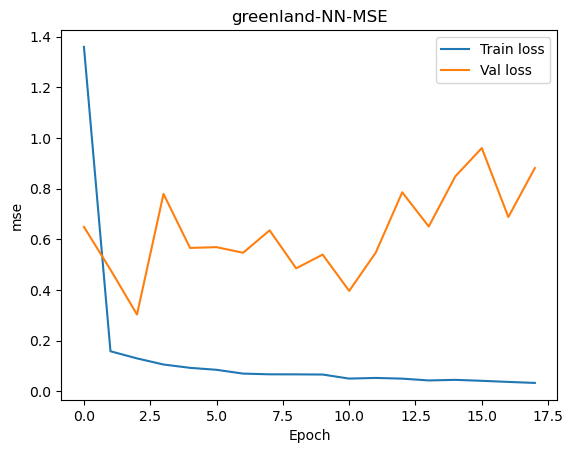

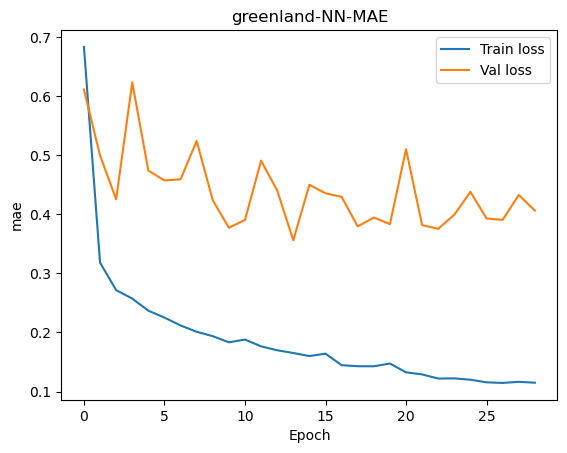

In [19]:
#plot loss value
# loss = "mse"
plt.plot(history_mse.history['loss'])
plt.plot(history_mse.history['val_loss'])
plt.title(f'{active_site}-{method}-MSE', fontsize=12)
plt.ylabel('mse')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')
plt.show()

# loss = "mae"
plt.plot(history_mae.history['loss'])
plt.plot(history_mae.history['val_loss'])
plt.title(f'{active_site}-{method}-MAE', fontsize=12)
plt.ylabel('mae')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')
plt.show()

In [20]:
model_path = os.path.join(cwd,'saved_model', active_site)
os.makedirs(model_path, exist_ok=True)
model_mse.save(os.path.join(model_path,'NN_mse_model.h5'))
model_mae.save(os.path.join(model_path, 'NN_mae_model.h5'))

##### CNN + Keras tuner

In [35]:
# set parameters
method = "CNN"

minibatch_size = 64
num_epochs     = 50
n_trials       = 30   # total number of trials in hyperparameter tuning

In [36]:
def CNN_model(hp):
    
    # options for hyperparameters
    hp_filters = hp.Choice('filters', values=[16,32,64])
    hp_kernel_size = hp.Choice('kernel_size', values=[2,3,4,5])
    hp_activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    hp_loss = hp.Choice('loss', values=['mse','mae'])
    
    # build CNN models according to the hyperparameters
    model = keras.models.Sequential()

    model.add(Dense(hp_filters, input_shape=x_train_np.shape[1:], activation=hp_activation)) 
    
    model.add(Conv2DTranspose(filters=hp_filters, kernel_size=hp_kernel_size, 
                              activation=hp_activation, strides=1, padding='same')) # shape: (n_lat, n_lon, filters)
    
    model.add(Conv2DTranspose(filters=hp_filters, kernel_size=hp_kernel_size, 
                              activation=hp_activation, strides=1, padding='same')) #strids =1 plus padding ="same", stay same shape
    
    model.add(Conv2DTranspose(filters=hp_filters, kernel_size=hp_kernel_size, 
                              activation=hp_activation, strides=1, padding='same'))
    
    model.add(Conv2DTranspose(filters=1, kernel_size=hp_kernel_size, 
                              activation="linear", padding="same")) 
    
    model.compile(loss=hp_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate))
    
    return model

In [37]:
random_tuner = keras_tuner.RandomSearch(CNN_model, 
                                        max_trials=n_trials,
                                        seed=5,
                                        objective='val_loss', 
                                        max_retries_per_trial=0,
                                        max_consecutive_failed_trials=3,
                                        directory='random_search', 
                                        project_name=f'{active_site}_random_search_CNN_30trials')

Reloading Tuner from random_search/greenland_random_search_CNN_30trials/tuner0.json


In [38]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

random_tuner.search(x_train_np, y_train_np,
                    batch_size = minibatch_size,
                    epochs = num_epochs, 
                    validation_split = 0.2, 
                    callbacks = [early_stop])


In [39]:
best_model = random_tuner.get_best_models()[0]
best_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5, 5, 16)          144       
                                                                 
 conv2d_transpose (Conv2DTra  (None, 5, 5, 16)         4112      
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 5, 5, 16)         4112      
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 5, 5, 16)         4112      
 ranspose)                                                       
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 5, 5, 1)          257       
 ranspose)                                              

In [40]:
# best hyperparameters
best_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)[0]
print(best_hps.values)
# top2 hyperparameters
top2_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)[1]

{'filters': 16, 'kernel_size': 4, 'activation': 'relu', 'learning_rate': 0.001, 'loss': 'mse'}


In [41]:
# model_best
model_best = random_tuner.hypermodel.build(best_hps)
history_best = model_best.fit(x_train_np, y_train_np,
                              batch_size      = minibatch_size,
                              epochs          = num_epochs,
                              validation_split= 0.2, 
                              verbose         = 1,
                              callbacks       = [early_stop])

# model top2
model_top2 = random_tuner.hypermodel.build(top2_hps)
history_top2 = model_top2.fit(x_train_np, y_train_np,
                              batch_size      = minibatch_size,
                              epochs          = num_epochs,
                              validation_split= 0.2, 
                              verbose         = 1,
                              callbacks       = [early_stop])

Epoch 1/50
119/119 [==============================] - 1s 6ms/step - loss: 4.1442 - val_loss: 0.7127
Epoch 2/50
119/119 [==============================] - 1s 5ms/step - loss: 0.3966 - val_loss: 0.5866
Epoch 3/50
119/119 [==============================] - 1s 5ms/step - loss: 0.2269 - val_loss: 0.5230
Epoch 4/50
119/119 [==============================] - 1s 5ms/step - loss: 0.1877 - val_loss: 0.5706
Epoch 5/50
119/119 [==============================] - 1s 5ms/step - loss: 0.1719 - val_loss: 0.4292
Epoch 6/50
119/119 [==============================] - 1s 5ms/step - loss: 0.1564 - val_loss: 0.4705
Epoch 7/50
119/119 [==============================] - 1s 5ms/step - loss: 0.1419 - val_loss: 0.4100
Epoch 8/50
119/119 [==============================] - 1s 4ms/step - loss: 0.1301 - val_loss: 0.2445
Epoch 9/50
119/119 [==============================] - 1s 5ms/step - loss: 0.1278 - val_loss: 0.3432
Epoch 10/50
119/119 [==============================] - 1s 5ms/step - loss: 0.1139 - val_loss: 0.2433

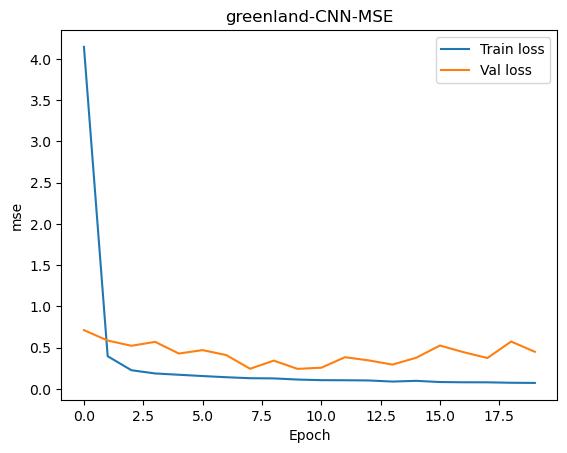

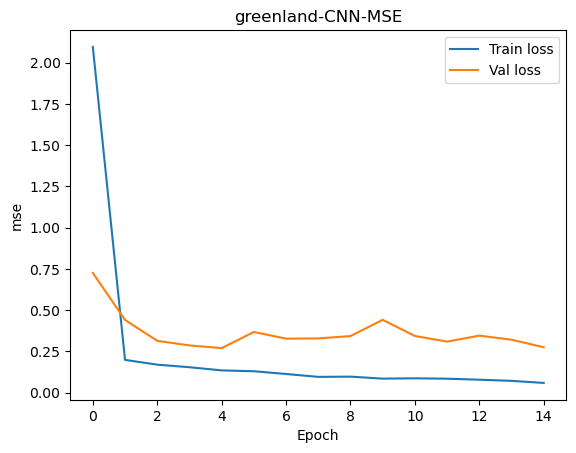

In [42]:
# set up title and ylabel strings

title_best = f"{active_site}-{method}-" + str(best_hps['loss']).upper()
ylabel_best = best_hps['loss']

title_top2 = f"{active_site}-{method}-" + str(best_hps['loss']).upper()
ylabel_top2 = top2_hps['loss']


# plot loss
#best
plt.plot(history_best.history['loss'])
plt.plot(history_best.history['val_loss'])
plt.title(title_best, fontsize=12)
plt.ylabel(ylabel_best)
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')
plt.show()

#top2
plt.plot(history_top2.history['loss'])
plt.plot(history_top2.history['val_loss'])
plt.title(title_top2, fontsize=12)
plt.ylabel(ylabel_top2)
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')
plt.show()

In [44]:
model_path = os.path.join(cwd,'saved_model', active_site)
os.makedirs(model_path, exist_ok=True)

model_best.save(os.path.join(model_path,'CNN_model_randomsearch_30trials_rank1.h5'))
model_top2.save(os.path.join(model_path,'CNN_model_randomsearch_30trials_rank2.h5'))

##### LSTM + keras tuner

In [45]:
# set hyperparameters
method = "LSTM"

num_epochs     = 50
minibatch_size = 64
n_trials = 12

In [46]:
def LSTM_model(hp):

    hp_neuron = hp.Choice('filters', values=[32, 64, 128])
    hp_activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    hp_loss = hp.Choice('loss', values=['mse','mae'])
    model = Sequential()
    model.add(Reshape((input_shape[0], flattened_spatial_dim), input_shape=input_shape))
    model.add(LSTM(hp_neuron, return_sequences=True, activation=hp_activation)) #if hp_neuron goes to large, return error, why?
    model.add(LSTM(hp_neuron, return_sequences=False, activation=hp_activation))
    model.add(Dense(output_shape[1] * output_shape[2], activation="linear"))
    model.add(Reshape(output_shape))

    model.compile(loss=hp_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate))
    return model


In [47]:
random_tuner = keras_tuner.RandomSearch(LSTM_model, 
                                        max_trials=n_trials,
                                        seed=5,
                                        objective='val_loss', 
                                        max_retries_per_trial=0,
                                        max_consecutive_failed_trials=3,
                                        directory='random_search', 
                                        project_name=f'{active_site}_random_search_LSTM_12trials')

Reloading Tuner from random_search/greenland_random_search_LSTM_12trials/tuner0.json


In [48]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

random_tuner.search(x_train_slider, y_train_slider,
                    batch_size = minibatch_size,
                    epochs = num_epochs, 
                    validation_split = 0.2, 
                    callbacks = [early_stop])

In [49]:
best_model = random_tuner.get_best_models()[0]
best_model.summary()

2023-12-22 01:14:21.992535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-22 01:14:21.994103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-22 01:14:21.995159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 5, 200)            0         
                                                                 
 lstm (LSTM)                 (None, 5, 64)             67840     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 25)                1625      
                                                                 
 reshape_1 (Reshape)         (None, 1, 5, 5)           0         
                                                                 
Total params: 102,489
Trainable params: 102,489
Non-trainable params: 0
_________________________________________________________________


In [50]:
best_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)[0]
top2_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)[1]
print(best_hps.values)

{'filters': 64, 'activation': 'tanh', 'learning_rate': 0.01, 'loss': 'mse'}


In [108]:
#Best
model_best = random_tuner.hypermodel.build(best_hps)

history_best = model_best.fit(x_train_slider, y_train_slider,
                              batch_size      = minibatch_size,
                              epochs          = num_epochs,
                              validation_split= 0.2, 
                              verbose         = 1,
                              callbacks       = [early_stop])

#Top2
model_top2 = random_tuner.hypermodel.build(top2_hps)

history_top2 = model_top2.fit(x_train_slider, y_train_slider,
                              batch_size      = minibatch_size,
                              epochs          = num_epochs,
                              validation_split= 0.2, 
                              verbose         = 1,
                              callbacks       = [early_stop])


2023-12-21 16:59:09.373725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-21 16:59:09.375377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-21 16:59:09.376285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2023-12-21 16:59:10.055113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-21 16:59:10.056712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-21 16:59:10.057753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

118/119 [============================>.] - ETA: 0s - loss: 5.2457

2023-12-21 16:59:15.661180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-21 16:59:15.662755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-21 16:59:15.663857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

119/119 [==============================] - 7s 33ms/step - loss: 5.2345 - val_loss: 1.1695
Epoch 2/50
119/119 [==============================] - 3s 24ms/step - loss: 2.1055 - val_loss: 0.4747
Epoch 3/50
119/119 [==============================] - 3s 25ms/step - loss: 0.8624 - val_loss: 0.5891
Epoch 4/50
119/119 [==============================] - 3s 24ms/step - loss: 0.3961 - val_loss: 0.7991
Epoch 5/50
119/119 [==============================] - 3s 26ms/step - loss: 0.2181 - val_loss: 0.9424
Epoch 6/50
119/119 [==============================] - 3s 25ms/step - loss: 0.1463 - val_loss: 1.0339
Epoch 7/50
119/119 [==============================] - 3s 24ms/step - loss: 0.1091 - val_loss: 0.9765
Epoch 8/50
119/119 [==============================] - 3s 24ms/step - loss: 0.0806 - val_loss: 0.9380
Epoch 9/50
119/119 [==============================] - 3s 25ms/step - loss: 0.0633 - val_loss: 0.8726
Epoch 10/50
119/119 [==============================] - 3s 25ms/step - loss: 0.0521 - val_loss: 0.8230


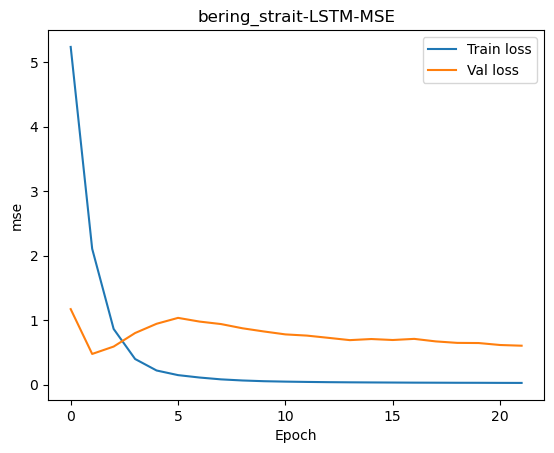

In [112]:
# set up title and ylabel strings
title_best = f"{active_site}-{method}-" + str(best_hps['loss']).upper()
ylabel_best = best_hps['loss']

title_top2 = f"{active_site}-{method}-" + str(best_hps['loss']).upper()
ylabel_top2 = top2_hps['loss']


# plot loss
#best
plt.plot(history_best.history['loss'])
plt.plot(history_best.history['val_loss'])
plt.title(title_best, fontsize=12)
plt.ylabel(ylabel_best)
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')
plt.show()

# #top2
# plt.plot(history_top2.history['loss'])
# plt.plot(history_top2.history['val_loss'])
# plt.title(title_top2, fontsize=12)
# plt.ylabel(ylabel_top2)
# plt.xlabel('Epoch')
# plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')
# plt.show()

In [114]:
model_path = os.path.join(cwd,'saved_model', active_site)
model_best.save(os.path.join(model_path,'LSTM_model_randomsearch_12trials_rank1.h5'))
model_top2.save(os.path.join(model_path,'LSTM_model_randomsearch_12trials_rank2.h5'))

##### CNN_LSTM + keras tuner

In [15]:
#set random search parameters
method = "CNN_LSTM"

n_trials = 10
minibatch_size = 64
num_epochs = 50
pool_size=2

In [16]:
### model using mse as loss function
def CNN_LSTM_model(hp):

    hp_filters = hp.Choice('filters', values=[32, 64, 128])
    hp_activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])
    hp_loss = hp.Choice('loss', values=['mse','mae'])
    hp_kernel = hp.Choice("kernel_size", values=[3, 4, 5])
    hp_lstm_unit = hp.Choice("lstm_unit", values=[25, 50])
    
    model = Sequential()

    model.add(Input(shape=(slider, n_lat,n_lon, (len(data_variables)-1))))
    model.add(TimeDistributed(Conv2D(hp_filters, (hp_kernel, hp_kernel), 
                                         padding='same', activation=hp_activation), 
                                         input_shape=(slider, n_lat,n_lon,(len(data_variables)-1))))
    model.add(TimeDistributed(AveragePooling2D(pool_size)))
    model.add(TimeDistributed(GlobalAveragePooling2D()))
    model.add(LSTM(hp_lstm_unit, activation=hp_activation))
    model.add(Dense(n_lat*n_lon))
    model.add(Activation('linear'))
    model.add(Reshape((1, n_lat, n_lon)))
    model.compile(loss=hp_loss,optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate))

    return model

In [17]:
random_tuner = keras_tuner.RandomSearch(CNN_LSTM_model, 
                                        max_trials=n_trials,
                                        seed=5,
                                        objective='val_loss', 
                                        max_retries_per_trial=0,
                                        max_consecutive_failed_trials=3,
                                        directory='random_search', 
                                        project_name=f'{active_site}_random_search_CNN_LSTM_10trials')

In [18]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
random_tuner.search(x_train_slider, y_train_slider,
                    batch_size = minibatch_size,
                    epochs = num_epochs, 
                    validation_split = 0.2, 
                    callbacks = [early_stop])

Trial 10 Complete [00h 00m 26s]
val_loss: 0.4506547749042511

Best val_loss So Far: 0.12238036841154099
Total elapsed time: 00h 06m 35s


In [19]:
best_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)[0]
top2_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)[1]
print(best_hps.values)

{'filters': 64, 'activation': 'tanh', 'learning_rate': 0.001, 'loss': 'mse', 'kernel_size': 3, 'lstm_unit': 50}


In [20]:
#Best
model_best = random_tuner.hypermodel.build(best_hps)

history_best = model_best.fit(x_train_slider, y_train_slider,
                              batch_size      = minibatch_size,
                              epochs          = num_epochs,
                              validation_split= 0.2, 
                              verbose         = 1,
                              callbacks       = [early_stop])

#Top2
model_top2 = random_tuner.hypermodel.build(top2_hps)

history_top2 = model_top2.fit(x_train_slider, y_train_slider,
                              batch_size      = minibatch_size,
                              epochs          = num_epochs,
                              validation_split= 0.2, 
                              verbose         = 1,
                              callbacks       = [early_stop])


Epoch 1/50


2023-12-22 02:10:11.802712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-22 02:10:11.804177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-22 02:10:11.805124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

118/119 [============================>.] - ETA: 0s - loss: 6.1875

2023-12-22 02:10:14.306390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-22 02:10:14.307808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-22 02:10:14.308812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

119/119 [==============================] - 3s 10ms/step - loss: 6.1569 - val_loss: 4.3627
Epoch 2/50
119/119 [==============================] - 1s 7ms/step - loss: 0.3588 - val_loss: 3.4892
Epoch 3/50
119/119 [==============================] - 1s 7ms/step - loss: 0.1698 - val_loss: 1.7690
Epoch 4/50
119/119 [==============================] - 1s 7ms/step - loss: 0.1222 - val_loss: 1.0286
Epoch 5/50
119/119 [==============================] - 1s 7ms/step - loss: 0.1060 - val_loss: 0.6770
Epoch 6/50
119/119 [==============================] - 1s 7ms/step - loss: 0.0958 - val_loss: 0.4805
Epoch 7/50
119/119 [==============================] - 1s 7ms/step - loss: 0.0869 - val_loss: 0.3300
Epoch 8/50
119/119 [==============================] - 1s 7ms/step - loss: 0.0781 - val_loss: 0.2142
Epoch 9/50
119/119 [==============================] - 1s 7ms/step - loss: 0.0732 - val_loss: 0.1333
Epoch 10/50
119/119 [==============================] - 1s 7ms/step - loss: 0.0690 - val_loss: 0.1503
Epoch 11/

2023-12-22 02:10:43.295062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-22 02:10:43.296709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-22 02:10:43.297728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

116/119 [============================>.] - ETA: 0s - loss: 5.5148

2023-12-22 02:10:45.975278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-22 02:10:45.976783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-22 02:10:45.977754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

119/119 [==============================] - 3s 11ms/step - loss: 5.4042 - val_loss: 3.5165
Epoch 2/50
119/119 [==============================] - 1s 8ms/step - loss: 0.3300 - val_loss: 2.8368
Epoch 3/50
119/119 [==============================] - 1s 8ms/step - loss: 0.1519 - val_loss: 1.0199
Epoch 4/50
119/119 [==============================] - 1s 8ms/step - loss: 0.1156 - val_loss: 0.5472
Epoch 5/50
119/119 [==============================] - 1s 8ms/step - loss: 0.0994 - val_loss: 0.3841
Epoch 6/50
119/119 [==============================] - 1s 8ms/step - loss: 0.0884 - val_loss: 0.2207
Epoch 7/50
119/119 [==============================] - 1s 8ms/step - loss: 0.0794 - val_loss: 0.1917
Epoch 8/50
119/119 [==============================] - 1s 8ms/step - loss: 0.0720 - val_loss: 0.1599
Epoch 9/50
119/119 [==============================] - 1s 8ms/step - loss: 0.0674 - val_loss: 0.1227
Epoch 10/50
119/119 [==============================] - 1s 8ms/step - loss: 0.0635 - val_loss: 0.1463
Epoch 11/

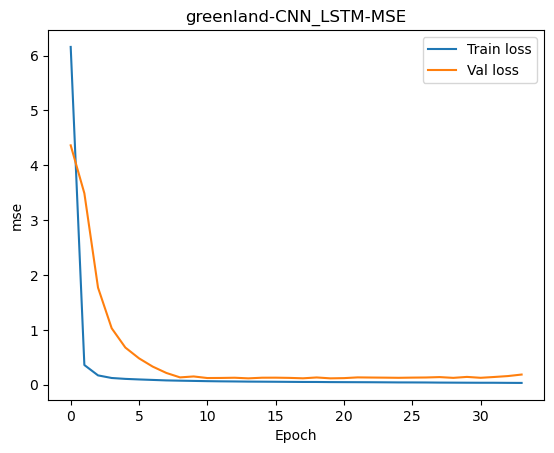

In [21]:
# set up title and ylabel strings
title_best = f"{active_site}-{method}-" + str(best_hps['loss']).upper()
ylabel_best = best_hps['loss']

title_top2 = f"{active_site}-{method}-" + str(best_hps['loss']).upper()
ylabel_top2 = top2_hps['loss']


# plot loss
#best
plt.plot(history_best.history['loss'])
plt.plot(history_best.history['val_loss'])
plt.title(title_best, fontsize=12)
plt.ylabel(ylabel_best)
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')
plt.show()

# #top2
# plt.plot(history_top2.history['loss'])
# plt.plot(history_top2.history['val_loss'])
# plt.title(title_top2, fontsize=12)
# plt.ylabel(ylabel_top2)
# plt.xlabel('Epoch')
# plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')
# plt.show()

In [22]:
model_path = os.path.join(cwd,'saved_model', active_site)
model_best.save(os.path.join(model_path,'CNN_LSTM_model_randomsearch_10trials_rank1.h5'))
model_top2.save(os.path.join(model_path,'CNN_LSTM_model_randomsearch_10trials_rank2.h5'))

#### Test Model
- NN
- NN + keras tuner
- CNN + keras tuner
- LSTM + keras tuner
- CNN_LSTM + keras tuner

In [71]:
model_path = os.path.join(cwd,'saved_model', active_site)

##### NN

In [72]:
model_mse = load_model(os.path.join(model_path,'NN_mse_model.h5'))
model_mae = load_model(os.path.join(model_path,'NN_mae_model.h5'))

In [20]:
y_test_mse_pre = model_mse.predict(x_test_flattened)
y_test_mae_pre = model_mae.predict(x_test_flattened)

53/53 [==============================] - 0s 616us/step


In [21]:
y_test_mse_pre = y_test_mse_pre.reshape(y_test_mse_pre.shape[0], n_lat, n_lon)
y_test_mse_pre = xr.Dataset(coords={'time': x_test_xr.time.values, 
                                     'latitude': x_test_xr.latitude.values, 
                                     'longitude': x_test_xr.longitude.values},
                             data_vars=dict(sithick=(['time', 'latitude', 'longitude'], y_test_mse_pre)))

y_test_mae_pre = y_test_mae_pre.reshape(y_test_mae_pre.shape[0], n_lat, n_lon)
y_test_mae_pre = xr.Dataset(coords={'time': x_test_xr.time.values, 
                                     'latitude': x_test_xr.latitude.values, 
                                     'longitude': x_test_xr.longitude.values},
                             data_vars=dict(sithick=(['time', 'latitude', 'longitude'], y_test_mae_pre)))


In [22]:
y_test_mse_pre

<xarray.Dataset>
Dimensions:    (time: 1673, latitude: 5, longitude: 5)
Coordinates:
  * time       (time) datetime64[ns] 2019-01-01 2019-01-02 ... 2023-07-31
  * latitude   (latitude) float32 82.92 83.0 83.08 83.17 83.25
  * longitude  (longitude) float32 -58.08 -58.0 -57.92 -57.83 -57.75
Data variables:
    sithick    (time, latitude, longitude) float32 2.631 2.769 ... 3.181 3.331

In [23]:
print(y_test_np.shape)
y_test_np = xr.Dataset(coords={'time': x_test_xr.time.values, 
                                     'latitude': x_test_xr.latitude.values, 
                                     'longitude': x_test_xr.longitude.values},
                             data_vars=dict(sithick=(['time', 'latitude', 'longitude'], y_test_np)))

(1673, 5, 5)


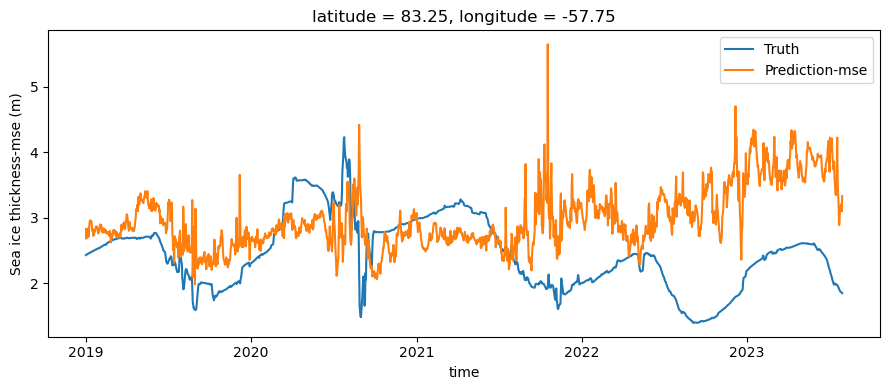

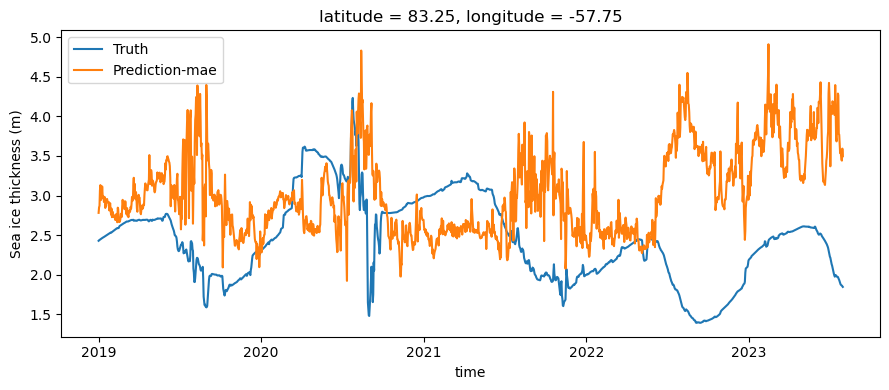

In [24]:
lat = 83.25
lon = -57.75
#mse
fig, ax = plt.subplots(figsize=(9, 4))
y_test_np.sel(latitude=lat, longitude=lon, method='nearest')["sithick"].plot(ax=ax, label='Truth')
y_test_mse_pre.sel(latitude=lat, longitude=lon, method='nearest')["sithick"].plot(ax=ax, label='Prediction-mse')

ax.legend()
ax.set_ylabel('Sea ice thickness-mse (m)') 

plt.tight_layout()
plt.show()
#mae
fig, ax = plt.subplots(figsize=(9, 4))
y_test_np.sel(latitude=lat, longitude=lon, method='nearest')["sithick"].plot(ax=ax, label='Truth')
y_test_mae_pre.sel(latitude=lat, longitude=lon, method='nearest')["sithick"].plot(ax=ax, label='Prediction-mae')

ax.legend()
ax.set_ylabel('Sea ice thickness (m)') 

plt.tight_layout()
plt.show()

In [25]:
def global_mean_std_plot(X, label, color, ax, var='sithick'):
    weights = np.cos(np.deg2rad(X.latitude))
    sithick_mean = X[var].weighted(weights).mean(['latitude', 'longitude']).data
    sithick_std = X[var].weighted(weights).std(['latitude', 'longitude']).data
    
    x = X.time.data

    ax.plot(x, sithick_mean, label=label, color=color, linewidth=2)
    ax.fill_between(x, sithick_mean+sithick_std, sithick_mean-sithick_std, facecolor=color, alpha=0.2)

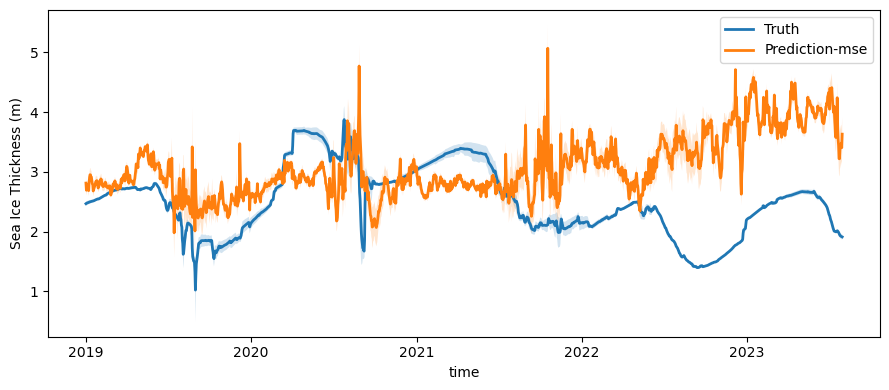

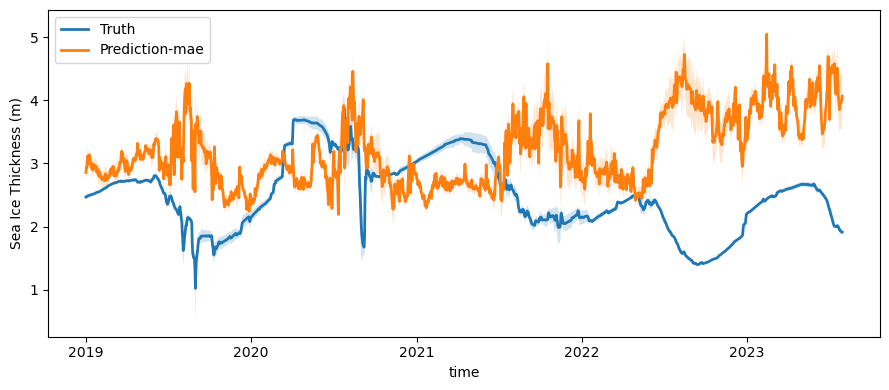

In [26]:
fig,ax = plt.subplots(figsize=(9,4))
#mse
global_mean_std_plot(y_test_np,label='Truth',ax=ax,color='tab:blue')
global_mean_std_plot(y_test_mse_pre,label='Prediction-mse',ax=ax,color='tab:orange')

ax.set_xlabel('time')
ax.set_ylabel('Sea Ice Thickness (m)')
ax.legend()
plt.tight_layout()

fig,ax = plt.subplots(figsize=(9,4))
#mae
global_mean_std_plot(y_test_np,label='Truth',ax=ax,color='tab:blue')
global_mean_std_plot(y_test_mae_pre,label='Prediction-mae',ax=ax,color='tab:orange')

ax.set_xlabel('time')
ax.set_ylabel('Sea Ice Thickness (m)')
ax.legend()
plt.tight_layout()

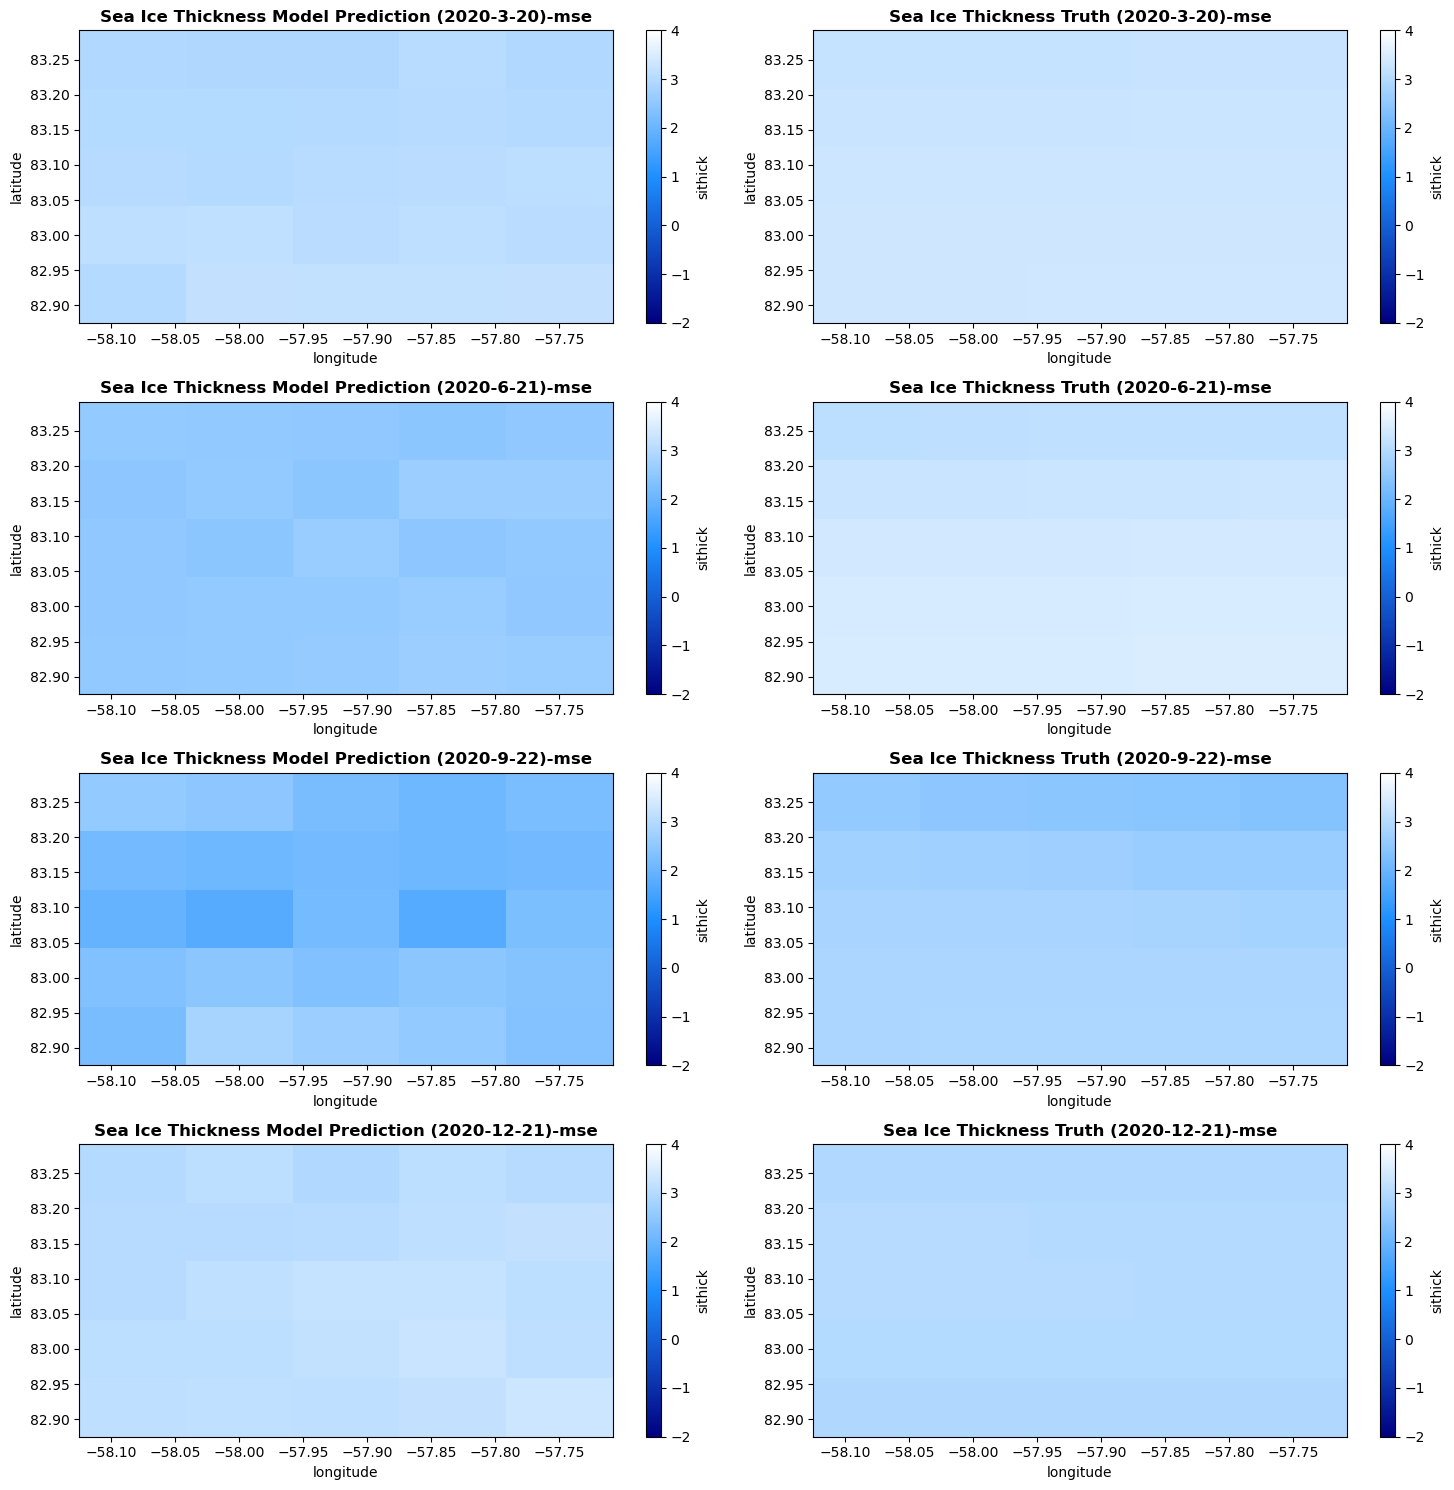

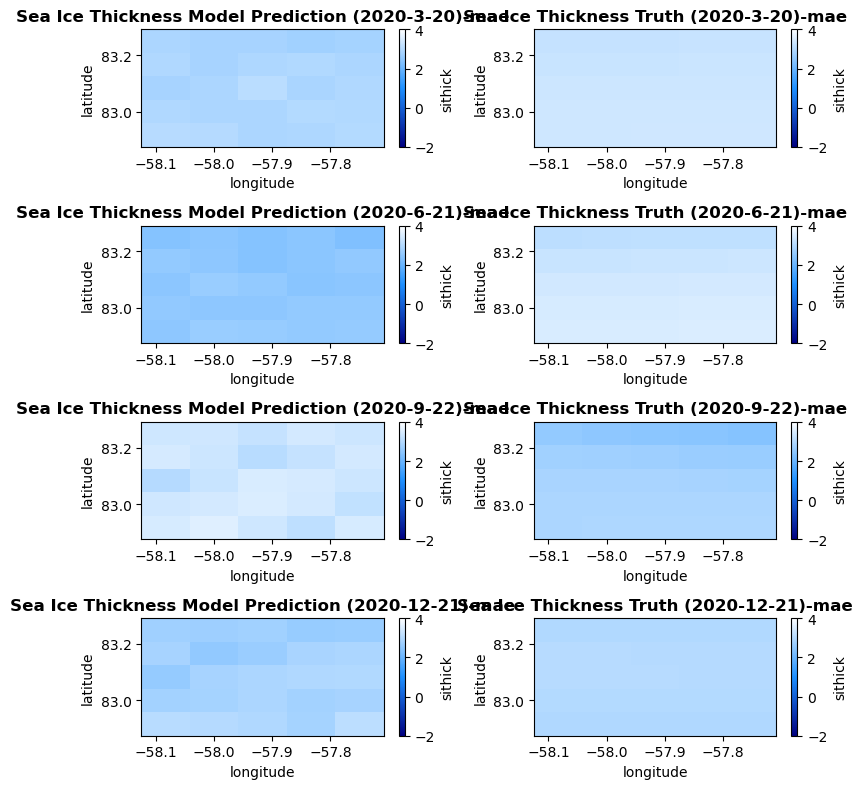

In [27]:
from matplotlib.colors import LinearSegmentedColormap as color
#mse
fig, axes = plt.subplots(figsize=(15, 15), ncols=2, nrows=4)  
season = ["2020-3-20", "2020-6-21", "2020-9-22", "2020-12-21"]
vmin, vmax = -2, 4
colors = ["navy", "dodgerblue","white"]
cmap = color.from_list("custom_cmap", colors)

for i, date in enumerate(season):
    y_test_mse_pre.sithick.sel(time=date).plot(ax=axes[i, 0], vmin=vmin, vmax=vmax, cmap=cmap)
    y_test_np.sithick.sel(time=date).plot(ax=axes[i, 1], vmin=vmin, vmax=vmax, cmap=cmap)
    axes[i, 0].set_title(f'Sea Ice Thickness Model Prediction ({date})-mse', fontweight='bold')
    axes[i, 1].set_title(f'Sea Ice Thickness Truth ({date})-mse', fontweight='bold')

plt.tight_layout()
plt.show()

#mae
fig, axes = plt.subplots(figsize=(8, 8), ncols=2, nrows=4)
yrs = ["2020-3-20", "2020-6-21", "2020-9-22", "2020-12-21"]
vmin, vmax = -2, 4
colors = ["navy", "dodgerblue","white"]
cmap = color.from_list("custom_cmap", colors)

for i, date in enumerate(yrs):
    y_test_mae_pre.sithick.sel(time=date).plot(ax=axes[i, 0], vmin=vmin, vmax=vmax, cmap=cmap)
    y_test_np.sithick.sel(time=date).plot(ax=axes[i, 1], vmin=vmin, vmax=vmax, cmap=cmap)
    axes[i, 0].set_title(f'Sea Ice Thickness Model Prediction ({date})-mae', fontweight='bold')
    axes[i, 1].set_title(f'Sea Ice Thickness Truth ({date})-mae', fontweight='bold')

plt.tight_layout()
plt.show()

In [28]:
##### fail to make 
import matplotlib.animation as animation

colors = ["navy", "dodgerblue", "white"]
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

fig, ax = plt.subplots(figsize=(15, 15), ncols=2, nrows=1)
vmin, vmax = -2, 4

def init():
    ax1.clear()
    ax1.set_title('Initializing...')
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    
    ax2.clear()
    ax2.set_title('Initializing...')
    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Latitude')
    
    return ax1, ax2

def update(frame):
    date = frame
    for i in range(1):
        axes[i, 0].clear()
        axes[i, 1].clear()

    y_test_mse_pre.sithick.sel(time=date).plot(ax=ax1, vmin=vmin, vmax=vmax, cmap=cmap)
    ax1.set_title(f'Sea Ice Thickness Model Prediction ({date.strftime("%Y-%m-%d")})-mse', fontweight='bold')

    y_test_np.sithick.sel(time=date).plot(ax=ax2, vmin=vmin, vmax=vmax, cmap=cmap)
    ax2.set_title(f'Sea Ice Thickness Truth ({date.strftime("%Y-%m-%d")})-mse', fontweight='bold')

    return ax1, ax2

dates = pd.date_range('2020-01-01', '2020-12-31', freq='MS')
ani = animation.FuncAnimation(fig, update, frames=dates, init_func=init, blit=False)
plt.show()

NameError: name 'LinearSegmentedColormap' is not defined

##### CNN + keras tuner

In [73]:
## reload the saved model
model_best = load_model(os.path.join(model_path,'CNN_model_randomsearch_30trials_rank1.h5'))
model_top2 = load_model(os.path.join(model_path,'CNN_model_randomsearch_30trials_rank2.h5'))


In [ ]:
y_test_best_pre = model_best.predict(x_test_np)
y_test_best_pre = y_test_best_pre.reshape(y_test_best_pre.shape[0], n_lat, n_lon)
y_test_best_pre = xr.Dataset(coords={'time': x_test_xr.time.values, 
                                     'latitude': x_test_xr.latitude.values, 
                                     'longitude': x_test_xr.longitude.values},
                             data_vars=dict(sithick=(['time', 'latitude', 'longitude'], y_test_best_pre)))
# ---------- rank #2 tuning ----------
y_test_top2_pre = model_top2.predict(x_test_np)
y_test_top2_pre = y_test_top2_pre.reshape(y_test_top2_pre.shape[0], n_lat, n_lon)
y_test_top2_pre = xr.Dataset(coords={'time': x_test_xr.time.values, 
                                     'latitude': x_test_xr.latitude.values, 
                                     'longitude': x_test_xr.longitude.values},
                             data_vars=dict(sithick=(['time', 'latitude', 'longitude'], y_test_top2_pre)))


##### LSTM + keras tuner

In [88]:
## reload the saved model
model_best = load_model(os.path.join(model_path,'LSTM_model_randomsearch_12trials_rank1.h5'))
model_top2 = load_model(os.path.join(model_path,'LSTM_model_randomsearch_12trials_rank2.h5'))


2023-12-22 00:39:36.167681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-22 00:39:36.169055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-22 00:39:36.170059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [ ]:
y_test_best_pre = model_best.predict(x_test_slider)
y_test_best_pre = y_test_best_pre.reshape(y_test_best_pre.shape[0], n_lat, n_lon)
y_test_best_pre = xr.Dataset(coords={'time': x_test_xr.time.values[slider-1:], 
                                     'latitude': x_test_xr.latitude.values, 
                                     'longitude': x_test_xr.longitude.values},
                             data_vars=dict(sithick=(['time', 'latitude', 'longitude'], y_test_best_pre)))
# ---------- rank #2 tuning ----------
y_test_top2_pre = model_top2.predict(x_test_slider)
y_test_top2_pre = y_test_top2_pre.reshape(y_test_top2_pre.shape[0], n_lat, n_lon)
y_test_top2_pre = xr.Dataset(coords={'time': x_test_xr.time.values[slider-1:], 
                                     'latitude': x_test_xr.latitude.values, 
                                     'longitude': x_test_xr.longitude.values},
                             data_vars=dict(sithick=(['time', 'latitude', 'longitude'], y_test_top2_pre)))

##### CNN_LSTM + keras tuner

In [ ]:
model_best = load_model(os.path.join(model_path,'CNN_LSTM_model_randomsearch_10trials_rank1.h5'))
model_top2 = load_model(os.path.join(model_path,'CNN_LSTM_model_randomsearch_10trials_rank2.h5'))